# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * scipy.randn(),
            'ss2': 2 + 10 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=53, start_time=2019-09-28 20:24:52.489329, end_time=None)>
INFO:Epsilon:initial epsilon is 7.781876893878387
INFO:ABC:t:0 eps:7.781876893878387
INFO:ABC:t:1 eps:4.8653472239439495
INFO:ABC:t:2 eps:3.067514136510668
INFO:ABC:t:3 eps:2.1159108805141167
INFO:ABC:t:4 eps:1.5457725975668968
INFO:ABC:t:5 eps:1.0556412298423927
INFO:ABC:t:6 eps:0.6726727174192657
INFO:ABC:t:7 eps:0.48511703811078094
INFO:History:Done <ABCSMC(id=53, start_time=2019-09-28 20:24:52.489329, end_time=2019-09-28 20:25:10.194703)>


Let us visualize the results for the non-adaptive distance:

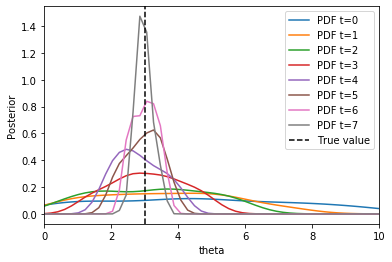

In [3]:
# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=54, start_time=2019-09-28 20:25:10.750697, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 1.5185904614397006, 'ss2': 0.48140953856029933}
INFO:Epsilon:initial epsilon is 6.0226887950285555
INFO:ABC:t:0 eps:6.0226887950285555
DEBUG:Distance:updated weights[1] = {'ss1': 1.5590231010469584, 'ss2': 0.44097689895304176}
INFO:ABC:t:1 eps:3.814274090746585
DEBUG:Distance:updated weights[2] = {'ss1': 1.6696155617251138, 'ss2': 0.3303844382748862}
INFO:ABC:t:2 eps:2.119239764263149
DEBUG:Distance:updated weights[3] = {'ss1': 1.7758427754948216, 'ss2': 0.2241572245051785}
INFO:ABC:t:3 eps:1.2729125246865642
DEBUG:Distance:updated weights[4] = {'ss1': 1.8738099252964462, 'ss2': 0.12619007470355378}
INFO:ABC:t:4 eps:0.7472759042118992
DEBUG:Distance:updated weights[5] = {'ss1': 1.9195504792124405, 'ss2': 0.08044952078755972}
INFO:ABC:t:5 eps:0.4049973353625381
DEBUG:Distance:updated weights[6] = {'ss1': 1.9544280773229952, 'ss2': 0.045571922677004786}
INF

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``pyabc.acceptor.accept_use_complete_history`` instead of the default ``pyabc.acceptor.accept_use_current_time`` in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

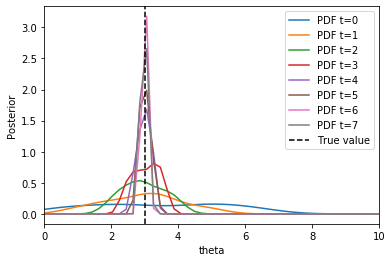

In [5]:
plot(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite, the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

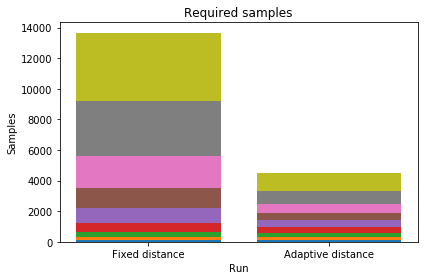

In [6]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. E.g., there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [7]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

INFO:History:Start <ABCSMC(id=55, start_time=2019-09-28 20:25:19.134891, end_time=None)>
INFO:Epsilon:initial epsilon is 3.734084659409626
INFO:ABC:t:0 eps:3.734084659409626
INFO:ABC:t:1 eps:3.1659314755027292
INFO:ABC:t:2 eps:3.0350359114085594
INFO:ABC:t:3 eps:3.008248466699831
INFO:ABC:t:4 eps:3.0005759714694262
INFO:History:Done <ABCSMC(id=55, start_time=2019-09-28 20:25:19.134891, end_time=2019-09-28 20:25:24.916506)>


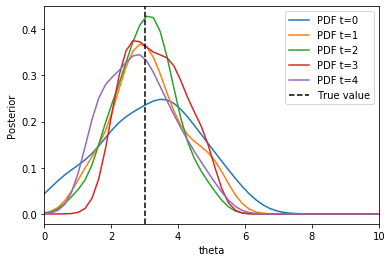

In [8]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot(history0)

INFO:History:Start <ABCSMC(id=56, start_time=2019-09-28 20:25:25.405940, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.006841222940376274, 'ss2': 1.9931587770596237}
INFO:Epsilon:initial epsilon is 5.975413812694851
INFO:ABC:t:0 eps:5.975413812694851
DEBUG:Distance:updated weights[1] = {'ss1': 0.006757358249202078, 'ss2': 1.993242641750798}
INFO:ABC:t:1 eps:5.958462955048106
DEBUG:Distance:updated weights[2] = {'ss1': 0.006743449553004719, 'ss2': 1.9932565504469952}
INFO:ABC:t:2 eps:5.949462529715861
DEBUG:Distance:updated weights[3] = {'ss1': 0.007125980171686117, 'ss2': 1.992874019828314}
INFO:ABC:t:3 eps:5.94091846991521
DEBUG:Distance:updated weights[4] = {'ss1': 0.007187179077515222, 'ss2': 1.9928128209224847}
INFO:ABC:t:4 eps:5.935310009079833
DEBUG:Distance:updated weights[5] = {'ss1': 0.00696187632378103, 'ss2': 1.9930381236762191}
INFO:History:Done <ABCSMC(id=56, start_time=2019-09-28 20:25:25.405940, end_time=2019-09-28 20:25:43.326554)>


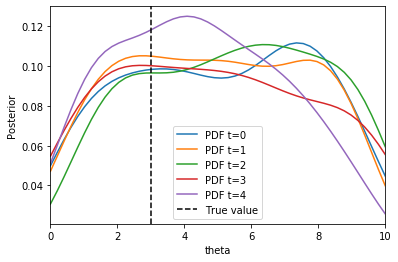

In [9]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot(history1)

These results are as expected: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take the bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

INFO:History:Start <ABCSMC(id=57, start_time=2019-09-28 20:25:43.913306, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.9114349786794799, 'ss2': 1.0885650213205202}
INFO:Epsilon:initial epsilon is 4.003580724964904
INFO:ABC:t:0 eps:4.003580724964904
DEBUG:Distance:updated weights[1] = {'ss1': 0.9083080266499025, 'ss2': 1.0916919733500976}
INFO:ABC:t:1 eps:3.469769065503335
DEBUG:Distance:updated weights[2] = {'ss1': 1.1767208875267519, 'ss2': 0.823279112473248}
INFO:ABC:t:2 eps:2.6250238942356705
DEBUG:Distance:updated weights[3] = {'ss1': 1.2058833684787078, 'ss2': 0.7941166315212921}
INFO:ABC:t:3 eps:2.4306181329792054
DEBUG:Distance:updated weights[4] = {'ss1': 1.322450944782817, 'ss2': 0.6775490552171829}
INFO:ABC:t:4 eps:2.049785359033221
DEBUG:Distance:updated weights[5] = {'ss1': 1.3453066743578947, 'ss2': 0.6546933256421053}
INFO:History:Done <ABCSMC(id=57, start_time=2019-09-28 20:25:43.913306, end_time=2019-09-28 20:25:48.430667)>


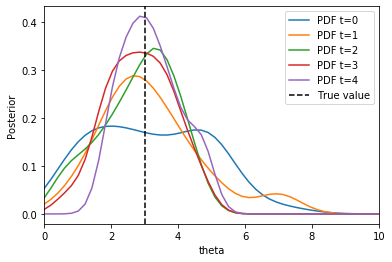

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot(history2)

In this setting, the accuracy and sample numbers are rougly back to the non-weighted case. Applying this method to the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

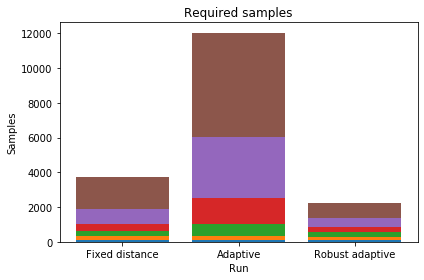

In [11]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Weighting diverse data with multiplicities

The problem setting we consider now is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

In [12]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt
import logging

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.INFO)

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

First, we consider uniform weights of 1:

In [13]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=8)

INFO:History:Start <ABCSMC(id=58, start_time=2019-09-28 20:25:49.110956, end_time=None)>
INFO:Epsilon:initial epsilon is 502.5829853079545
INFO:ABC:t:0 eps:502.5829853079545
INFO:ABC:t:1 eps:241.97855027460628
INFO:ABC:t:2 eps:122.26613157853268
INFO:ABC:t:3 eps:63.0504861587844
INFO:ABC:t:4 eps:38.41728646141517
INFO:ABC:t:5 eps:19.158304292138887
INFO:ABC:t:6 eps:11.20711930848582
INFO:ABC:t:7 eps:7.45511477645901
INFO:History:Done <ABCSMC(id=58, start_time=2019-09-28 20:25:49.110956, end_time=2019-09-28 20:26:48.125392)>


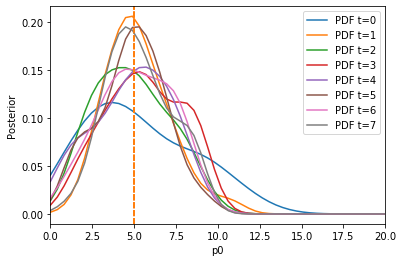

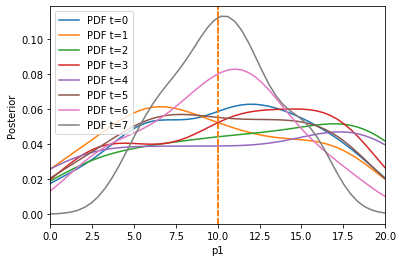

In [14]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=59, start_time=2019-09-28 20:26:49.171154, end_time=None)>
INFO:Epsilon:initial epsilon is 644.1169400608517
INFO:ABC:t:0 eps:644.1169400608517
INFO:ABC:t:1 eps:265.2725682507346
INFO:ABC:t:2 eps:158.62629630730726
INFO:ABC:t:3 eps:75.9799194957333
INFO:ABC:t:4 eps:39.81050305127149
INFO:ABC:t:5 eps:23.247211866326698
INFO:ABC:t:6 eps:12.807308137043703
INFO:ABC:t:7 eps:7.041076048515231
INFO:History:Done <ABCSMC(id=59, start_time=2019-09-28 20:26:49.171154, end_time=2019-09-28 20:27:35.707906)>


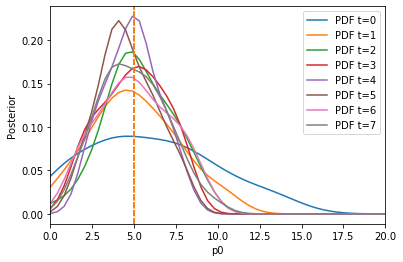

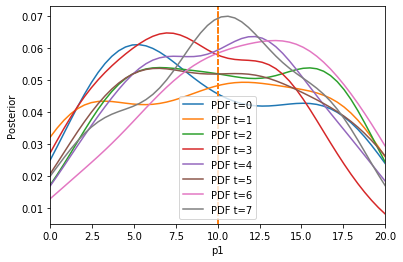

In [15]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=8)

plot(history2)

Next, we account for the discrepancy in data point counts by using self-defined scaling factors:

INFO:History:Start <ABCSMC(id=60, start_time=2019-09-28 20:27:36.773144, end_time=None)>
INFO:Epsilon:initial epsilon is 10.316197885529528
INFO:ABC:t:0 eps:10.316197885529528
INFO:ABC:t:1 eps:7.5161642084808395
INFO:ABC:t:2 eps:4.967777905589916
INFO:ABC:t:3 eps:3.406350245241559
INFO:ABC:t:4 eps:2.634818861307313
INFO:ABC:t:5 eps:1.9020516367039
INFO:ABC:t:6 eps:1.2217894372267846
INFO:ABC:t:7 eps:0.9064748465032822
INFO:History:Done <ABCSMC(id=60, start_time=2019-09-28 20:27:36.773144, end_time=2019-09-28 20:28:07.486085)>


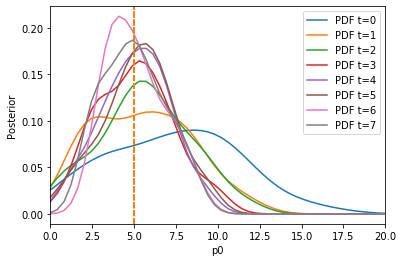

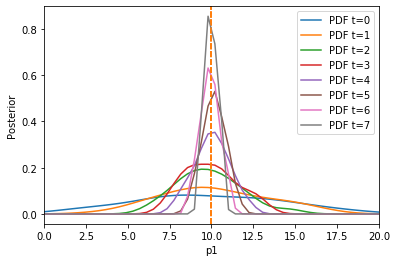

In [16]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=8)

plot(history3)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=61, start_time=2019-09-28 20:28:08.729444, end_time=None)>
INFO:Epsilon:initial epsilon is 10.265203690823038
INFO:ABC:t:0 eps:10.265203690823038
INFO:ABC:t:1 eps:6.501292988038549
INFO:ABC:t:2 eps:4.699747208326358
INFO:ABC:t:3 eps:3.9748519021323103
INFO:ABC:t:4 eps:2.947759509578383
INFO:ABC:t:5 eps:2.1922969941421355
INFO:ABC:t:6 eps:2.1434821073171415
INFO:ABC:t:7 eps:1.7957682666714438
INFO:History:Done <ABCSMC(id=61, start_time=2019-09-28 20:28:08.729444, end_time=2019-09-28 20:28:36.316469)>


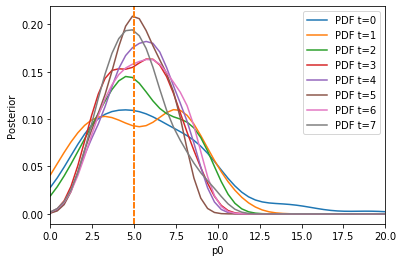

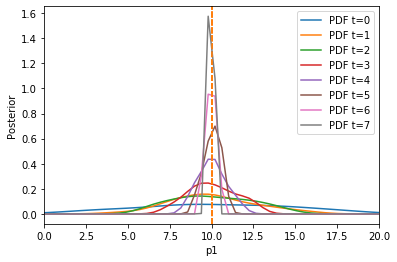

In [17]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=8)

plot(history4)

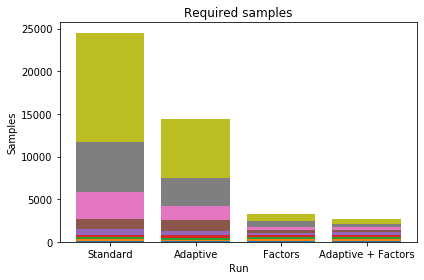

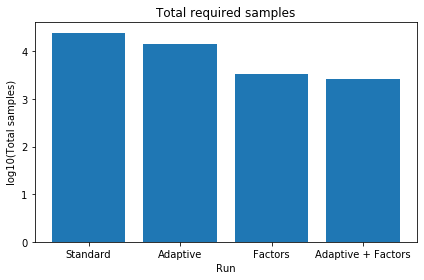

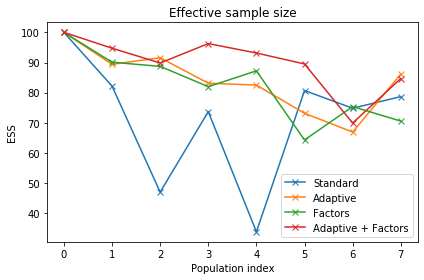

In [18]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)